### Exploracion de datos faltantes de un restaurante

In [5]:
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import session_info
import upsetplot
from fs import open_fs
from pathlib import Path
import shutil # Necesario para la operación de movimiento de archivos
import sys
from pathlib import Path

# This code snippet is used to import a custom Python module named 'pandas_missing_extension.py'
# located in the parent directory of the current notebook.
# 1. Get the path of the current notebook (where live-exploration-missing-values.ipynb is)
#    This will give you something like:
#    /home/paco/datos_faltantes/curso-datos-faltantes-main/jupyter/live-exploration-missing-values.ipynb
current_notebook_path = Path.cwd() # Path.cwd() returns the current working directory of the kernel

# 2. Navigate up one level to find the directory containing 'pandas_missing_extension.py'
#    This will give you:
#    /home/paco/datos_faltantes/curso-datos-faltantes-main/
project_root_dir = current_notebook_path.parent

# 3. Add this directory to Python's system path if it's not already there
#    This allows Python to find modules in this directory.
if str(project_root_dir) not in sys.path:
    sys.path.append(str(project_root_dir))
    print(f"Added {project_root_dir} to sys.path")

# 4. Now, import your custom accessor module
#    Python will now find 'pandas_missing_extension.py' in the added path.
import pandas_missing_extension
import warnings

# Puedes ser más específico con el tipo de advertencia si lo conoces, por ejemplo:
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

# Para las advertencias relacionadas con pkg_resources (como las de tu captura):
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API")
warnings.filterwarnings("ignore", message="Deprecated call to pkg_resources.declare_namespace")


Added /home/paco/datos_faltantes/curso-datos-faltantes-main to sys.path


/home/paco/miniforge3/envs/datos_faltantes/lib/python3.9/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/paco/miniforge3/envs/datos_faltantes/lib/python3.9/site-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/paco/miniforge3/envs/datos_faltantes/lib/python3.9/site-packages/fs/__init__.py:4: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('fs')

_Carga de datos_

In [6]:
# Definir la ruta relativa directamente desde la ubicación del notebook
# '../' sube un nivel, 'data/' entra al directorio 'data'
csv_file_path = Path("../data/Datos_restaurante_con_valores_faltantes.csv")

# Verificar si la ruta del archivo existe (opcional, pero buena práctica)
if csv_file_path.exists():
    # Leer el archivo CSV en un DataFrame de pandas
    df = pd.read_csv(csv_file_path)
    print("Archivo CSV cargado exitosamente.")
    print(df.head()) # Muestra las primeras filas del DataFrame
else:
    print(f"Error: El archivo no se encontró en la ruta: {csv_file_path}")

Archivo CSV cargado exitosamente.
   ID_cliente  Edad Género Frecuencia_visita  Monto_gastado Tipo_pago  \
0         1.0  56.0      M           Semanal     929.686812       NaN   
1         2.0  69.0      M           Semanal     179.643252       NaN   
2         NaN  46.0      M           Semanal     276.384576   Tarjeta   
3         4.0  32.0      M            Diaria     140.704560       App   
4         5.0  60.0      F           Semanal     392.797298       App   

   Tiempo_espera  Calificación_servicio Plato_favorito Bebida_favorita  \
0           36.0                    3.0          Pasta         Cerveza   
1            8.0                    1.0          Pasta        Refresco   
2           34.0                    5.0            NaN             NaN   
3           41.0                    1.0          Tacos            Agua   
4           27.0                    3.0          Pasta         Cerveza   

  Recomendó Visitó_fin_de_semana    Propina  Satisfacción Comentario  \
0     Fals

In [7]:
df.shape  # Muestra las dimensiones del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID_cliente             24 non-null     float64
 1   Edad                   24 non-null     float64
 2   Género                 22 non-null     object 
 3   Frecuencia_visita      28 non-null     object 
 4   Monto_gastado          24 non-null     float64
 5   Tipo_pago              26 non-null     object 
 6   Tiempo_espera          27 non-null     float64
 7   Calificación_servicio  26 non-null     float64
 8   Plato_favorito         27 non-null     object 
 9   Bebida_favorita        28 non-null     object 
 10  Recomendó              27 non-null     object 
 11  Visitó_fin_de_semana   28 non-null     object 
 12  Propina                26 non-null     float64
 13  Satisfacción           26 non-null     float64
 14  Comentario             26 non-null     object 
 15  Tipo_com

## Tablas

#### Variables / columnas

In [8]:
df.missing.missing_variable_table()

,n_missing_in_variable,n_variables,pct_variables
0,4,7,35.0
1,2,4,20.0
2,6,4,20.0
3,3,3,15.0
4,5,1,5.0
5,8,1,5.0


### Casos / Observaciones / Filas

In [9]:
df.missing.missing_case_table()

,n_missing_in_case,n_cases,pct_case
0,2,10,33.333333
1,4,5,16.666667
2,1,4,13.333333
3,0,3,10.000000
4,3,3,10.000000
5,5,2,6.666667
6,6,2,6.666667
7,7,1,3.333333


In [10]:
df.missing.missing_variable_span(variable='Edad',span_every=5)

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,0,5,0.0,100.0
1,1,1,4,20.0,80.0
2,2,3,2,60.0,40.0
3,3,2,3,40.0,60.0
4,4,0,5,0.0,100.0
5,5,0,5,0.0,100.0


In [11]:
df.missing.missing_variable_run(variable='Edad')

,run_length,is_na
0,8,complete
1,1,missing
2,1,complete
3,1,missing
4,1,complete
5,2,missing
6,3,complete
7,1,missing
8,1,complete
9,1,missing


### Visualización de valores faltantes

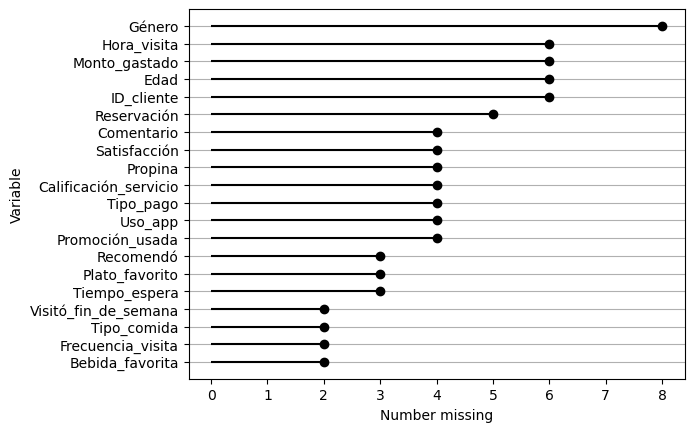

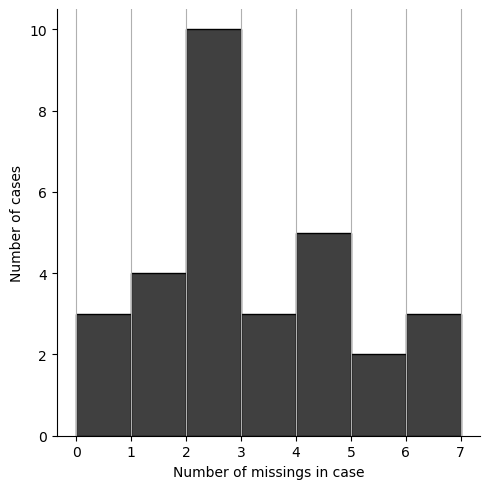

In [12]:
df.missing.missing_variable_plot()

### Casos / Observaciones / Filas

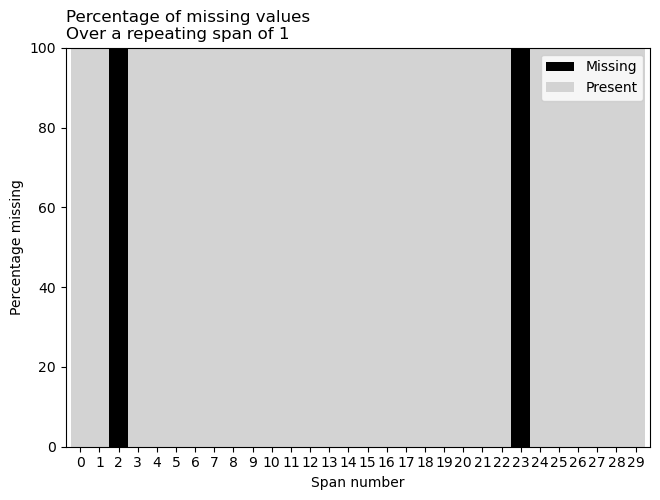

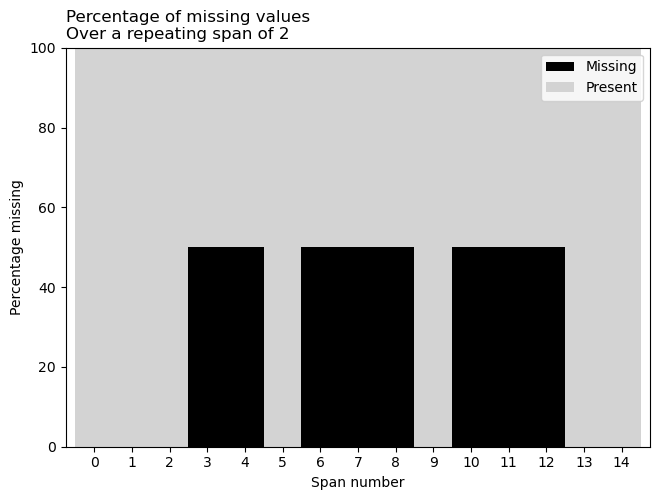

In [13]:
df.missing.missing_variable_span_plot(variable='Bebida_favorita', span_every=1)
df.missing.missing_variable_span_plot(variable='Género', span_every=2)

<AxesSubplot:>

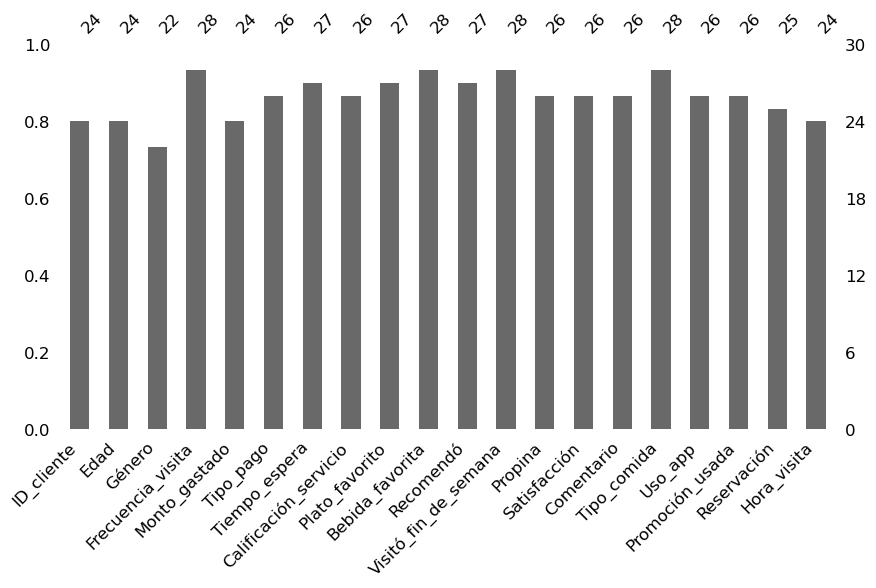

In [14]:
missingno.bar(df, figsize=(10, 5), fontsize=12)

<AxesSubplot:>

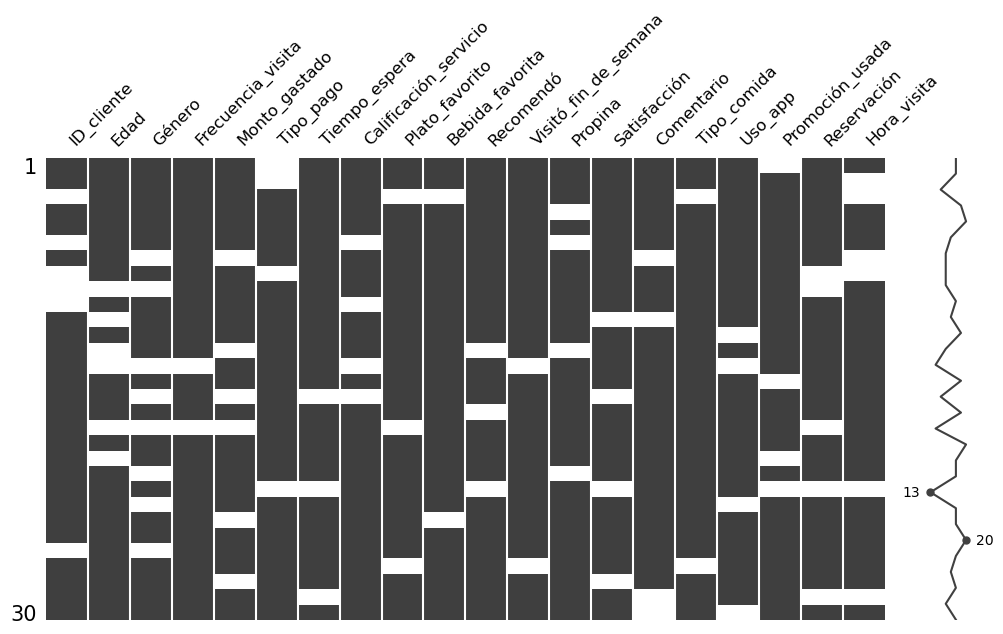

In [15]:
missingno.matrix(df, figsize=(12, 6), fontsize=12)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

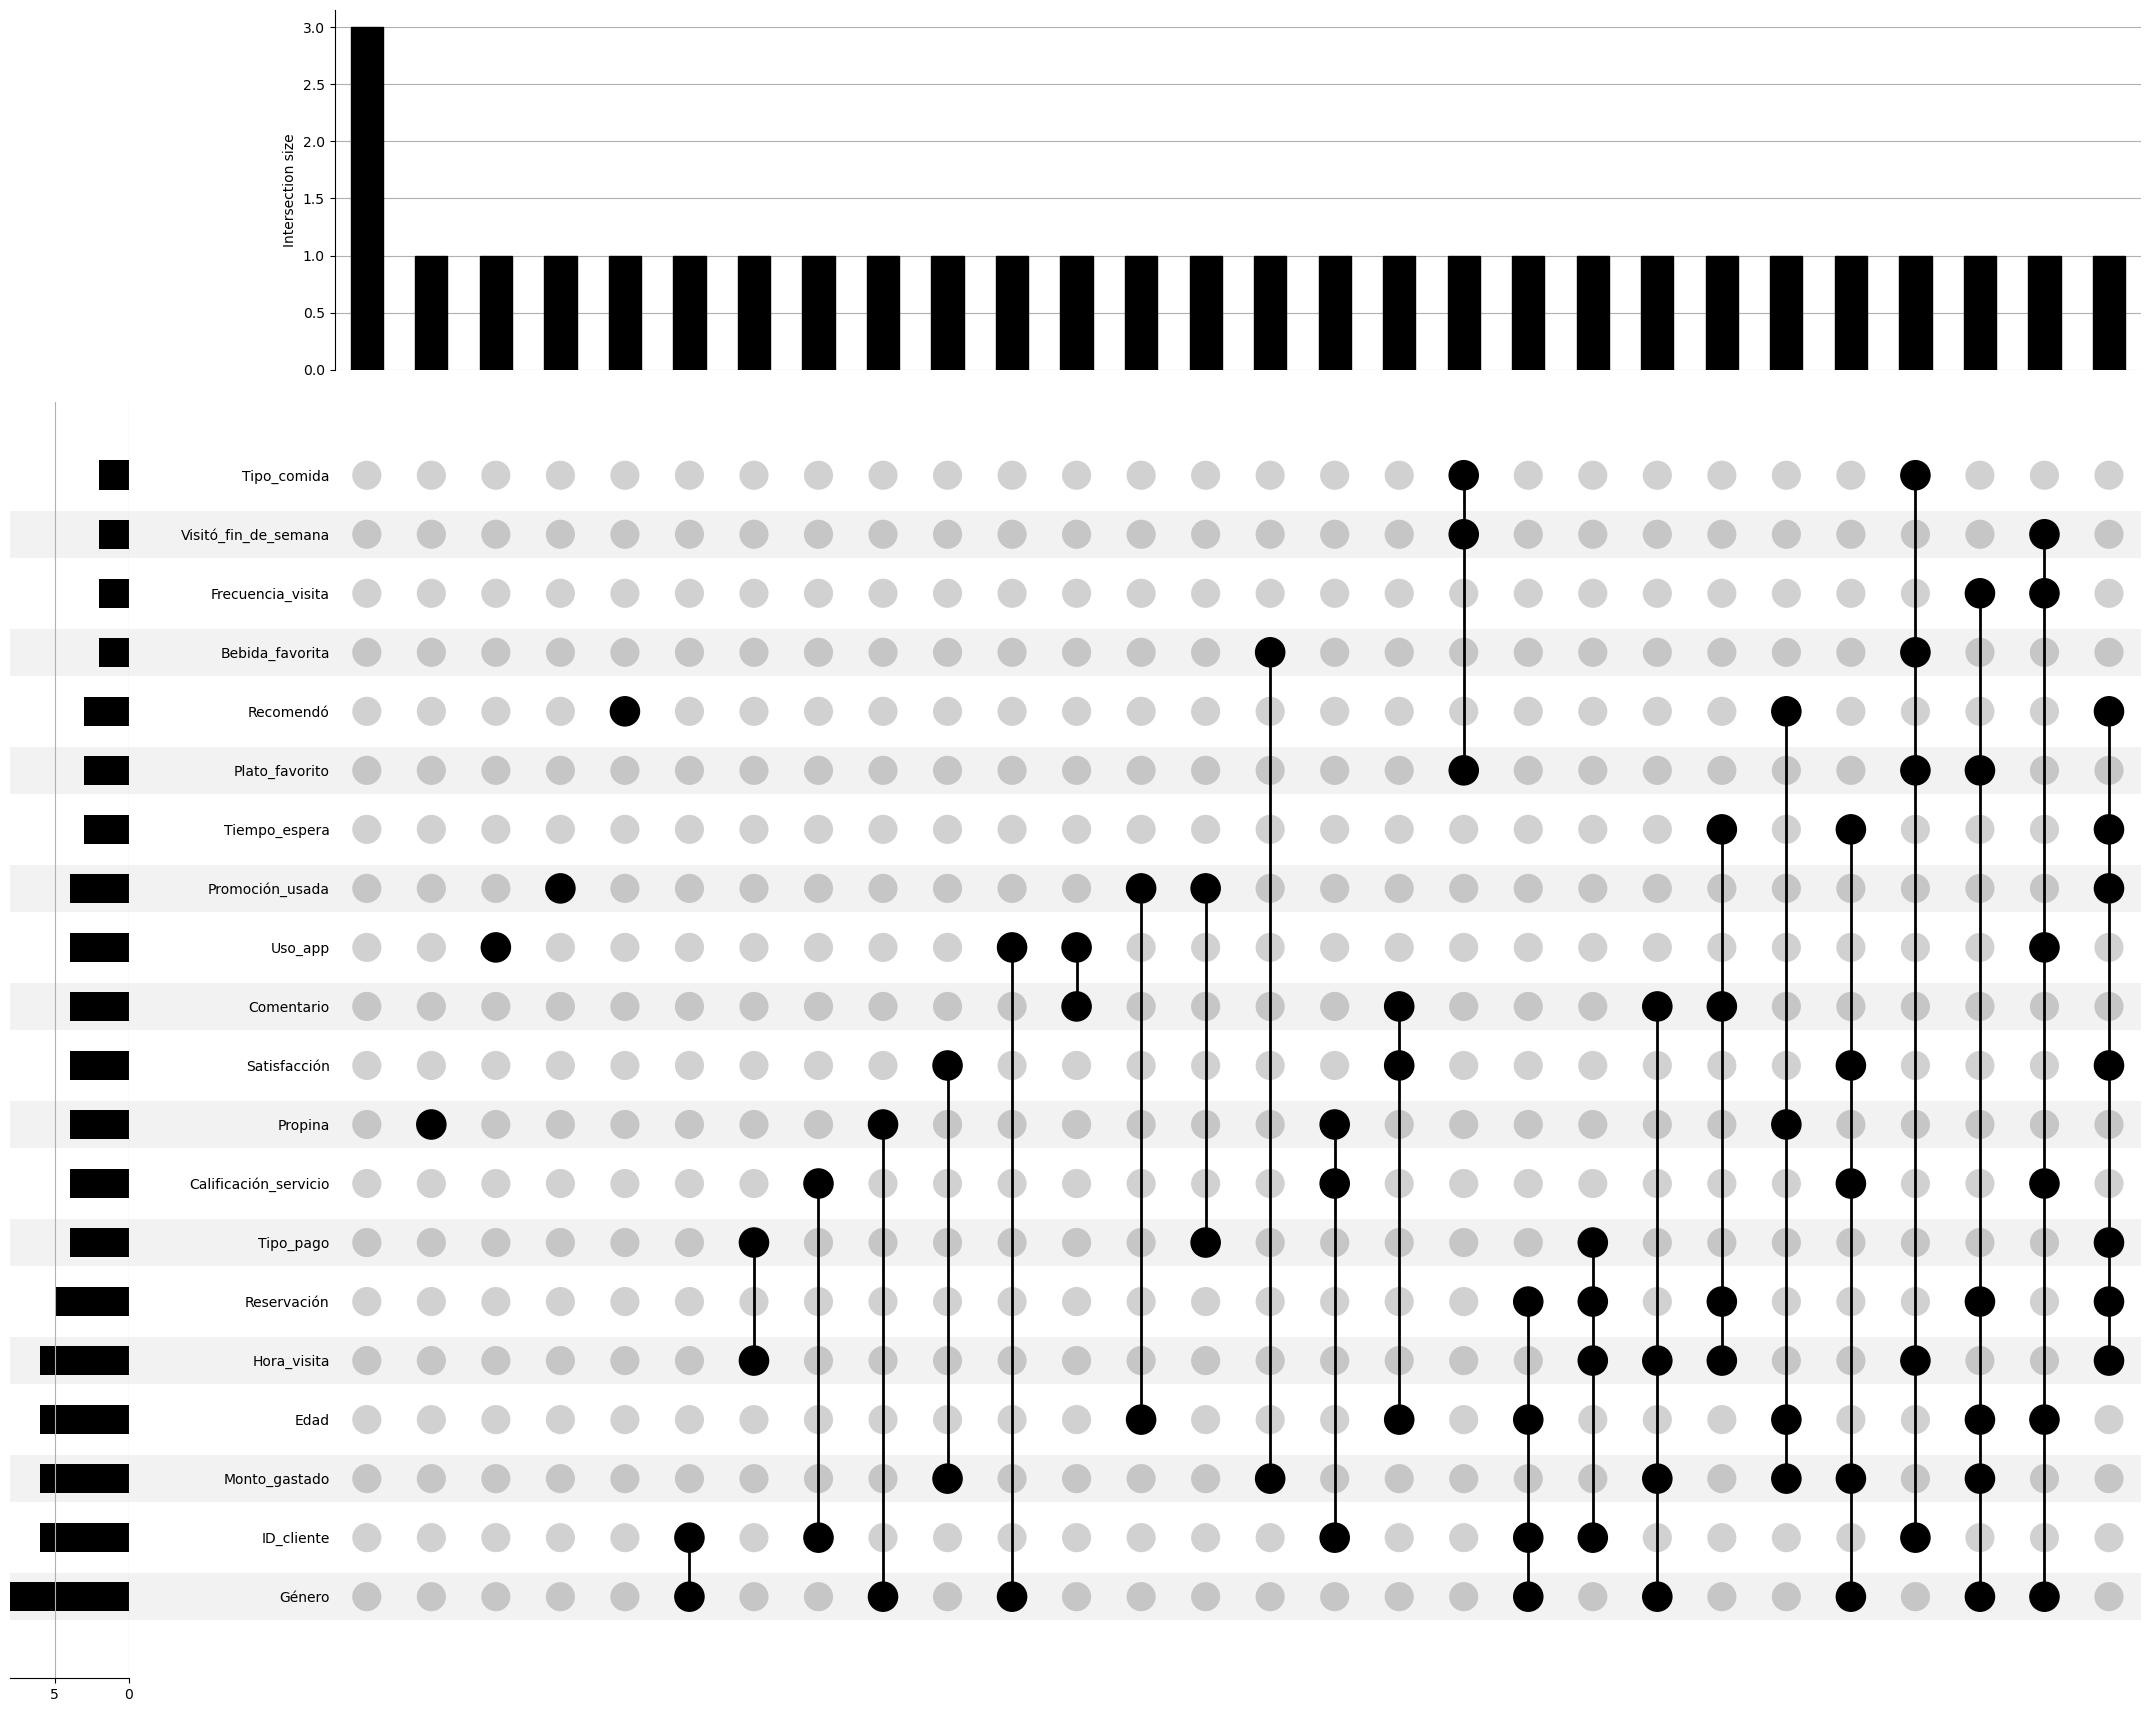

In [16]:
warnings.filterwarnings('ignore')
(df.missing.missing_upsetplot(
  variables=None,  # None para incluir todas las variables
  element_size=60,  # Tamaño de los elementos en el gráfico
))

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

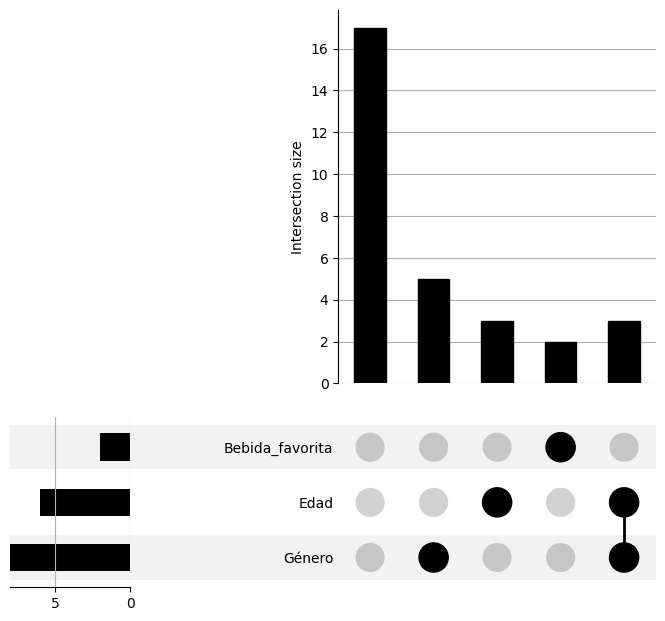

In [17]:
warnings.filterwarnings('ignore')
df.missing.missing_upsetplot(
  variables=['Bebida_favorita', 'Género', 'Edad'],  # Especifica las variables a incluir
  element_size=60,  # Tamaño de los elementos en el gráfico
)

In [18]:
df.columns

Index(['ID_cliente', 'Edad', 'Género', 'Frecuencia_visita', 'Monto_gastado',
       'Tipo_pago', 'Tiempo_espera', 'Calificación_servicio', 'Plato_favorito',
       'Bebida_favorita', 'Recomendó', 'Visitó_fin_de_semana', 'Propina',
       'Satisfacción', 'Comentario', 'Tipo_comida', 'Uso_app',
       'Promoción_usada', 'Reservación', 'Hora_visita'],
      dtype='object')

### Datos faltantes con diferentes codificaciones con datos de estudiantes de primaria

_Carga de datos local del .csv_

In [20]:
csv_file_path = Path('../data/Datos_de_Estudiantes_con_Valores_Faltantes.csv')

if csv_file_path.exists():
    df = pd.read_csv(csv_file_path)
    print('Archivo CSV de estudiantes cargado existosamente.')
else:
    print(f'Error: el archivo no se encontró en la ruta: {csv_file_path}')

Archivo CSV de estudiantes cargado existosamente.


In [23]:
df.missing.number_missing()

59

In [24]:
df

,Nombre,Edad,Grado,Promedio,Faltas,Tutor,Comedor,Actividades,Calificaciones_Matematicas,Calificaciones_Espanol
0,Ana,13,1°,8.5,2,Sr. López,Sí,Fútbol,8,9
1,Luis,14,2°,9.0,0,Sra. Díaz,No,NaN,9,10
2,Carlos,13,2°,7.8,3,Sr. Ramírez,Sí,Artes,7,8
3,NaN,15,3°,NaN,NaN,NaN,NaN,NaN,NaN,missing
4,Mónica,NaN,2°,8.9,NaN,NaN,NaN,Música,10,9
5,Jorge,14,1°,NaN,1,missing,NaN,missing,6,NaN
6,Sofía,13,3°,7.5,missing,NaN,NaN,NaN,7,NaN
7,Pedro,NaN,3°,9.1,0,Sr. Peña,Sí,Teatro,NaN,NaN
8,NaN,12,2°,NaN,4,NaN,No,NaN,NaN,NaN
9,Laura,14,1°,8.0,NaN,NaN,Sí,Fútbol,8,8


_Reemplazo dirigido y global_

In [37]:
# df_missing_data = (
#   df
#   .replace(
#     to_replace={
#       'Calificaciones_Espanol':{
#         'missing': np.nan
#       }
#     }
#   )
# )

df_missing_data = (
  df
  .replace(
    to_replace=['missing'],
    value=np.nan
  )
)

In [49]:
df_missing_data.missing.number_missing()

67

_Pivoteo de tablas de datos implicitos_

In [120]:
(
    df_missing_data
    .pivot_wider(
        index=['Nombre', 'Actividades'],    # Dos columnas como índice
        names_from='Grado',                 # Columna que convierte en los nombres de la tabla en columnas
        values_from='Faltas'                # Valores de la tabla
    )
)

,Nombre,Actividades,NaN,1°,2°,3°
0,NaN,NaN,1,NaN,4,NaN
1,NaN,Fútbol,NaN,NaN,NaN,2
2,Ana,Fútbol,NaN,2,NaN,NaN
3,Andrea,Robótica,0,NaN,NaN,NaN
4,Andrés,Teatro,NaN,NaN,NaN,3
5,Camila,NaN,NaN,1,NaN,NaN
6,Carlos,Artes,NaN,NaN,3,NaN
7,Diego,Fútbol,2,NaN,NaN,NaN
8,Iván,Robótica,NaN,NaN,NaN,NaN
9,Jorge,NaN,NaN,1,NaN,NaN


In [96]:
# df_largo = df_missing_data.melt(
#   id_vars=['Promedio'],
#   var_name='Promedio general',
#   value_name='Nombre del alumno'
# )
# df.promedio = df_largo.iloc[0:20,[0,2]]
# print(df.promedio)
# df.calif_espanol = df_largo.iloc[-20:,[0,2]]
# print(df.calif_espanol)
# df_largo.to_csv('../data/df_largo.csv', index=False)

# (
#   df_largo
#   .pivot_wider(
#    index='Nombre del alumno',
#    names_from='Nombre del alumno',
#    values_from='Promedio',
#    )
# )

   Promedio Nombre del alumno
0       8.5               Ana
1       9.0              Luis
2       7.8            Carlos
3       NaN               NaN
4       8.9            Mónica
5       NaN             Jorge
6       7.5             Sofía
7       9.1             Pedro
8       NaN               NaN
9       8.0             Laura
10      7.9              Iván
11      NaN            Camila
12      NaN             Diego
13      8.3             María
14      8.1            Andrés
15      8.2               NaN
16      9.0           Valeria
17      NaN              Raúl
18      7.8            Andrea
19      8.4               NaN
    Promedio Nombre del alumno
160      8.5                 9
161      9.0                10
162      7.8                 8
163      NaN               NaN
164      8.9                 9
165      NaN               NaN
166      7.5               NaN
167      9.1               NaN
168      NaN               NaN
169      8.0                 8
170      7.9                 

_Contador de n-tuplas_

In [129]:
(df_missing_data
 .value_counts(subset=['Calificaciones_Espanol'])
  .reset_index(name='count')
  .query('count > 1')
 )

,Calificaciones_Espanol,count
0,9,5
1,8,3
2,10,2
